In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
import math
import random

## Exploratory Data Analysis of subset FD003
Dataset FD001 contains the sensordata from run-to-failure experiments, simulated using the CMAPSS software. During the entire experiment, only two possible faults could occur and each timecycle happened under the same conditions.

### Reading in and transforming the data
I use the pandas library to read the data from the csv into a DataFrame. The sensordata gets min-max normalized.
Since the data is sensordata from "run-to-failure" experiments, it's safe to assume the last datapoint of each unit contains the data from the last cycle the unit was active. We can therefore create a RUL-column, counting down to this last cycle.

In [2]:
filepath = '../Data/CMAPSSData/train_FD003.txt'
index_columns = ['unit_nr', 'time_cycles']
setting_columns = ['setting_1', 'setting_2', 'setting_3']
sensor_columns = ['s_{}'.format(i) for i in range(1,22)]
columns = index_columns + setting_columns + sensor_columns
df = pd.read_csv(filepath, sep='\s+', header=None, names=columns)

scaler = MinMaxScaler()
df[sensor_columns] = pd.DataFrame(scaler.fit_transform(df[sensor_columns]))
df[sensor_columns] = 2*df[sensor_columns]-1

df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,-1.0,-0.288056,-0.258955,-0.382839,-1.0,...,-0.537443,0.285714,-0.521769,0.295509,-1.0,-0.454545,-1.0,-1.0,0.119048,-0.107338
1,1,2,0.0008,-0.0003,100.0,-1.0,-0.222482,-0.201801,-0.381279,-1.0,...,-0.526235,0.309524,-0.442867,0.371318,-1.0,-0.272727,-1.0,-1.0,-0.023810,0.069673
2,1,3,-0.0014,-0.0002,100.0,-1.0,-0.372365,-0.293404,-0.109204,-1.0,...,-0.565970,0.273810,-0.470949,0.128923,-1.0,-0.454545,-1.0,-1.0,-0.190476,-0.082846
3,1,4,-0.0020,0.0001,100.0,-1.0,-0.025761,-0.165786,-0.525429,-1.0,...,-0.519103,0.369048,-0.508776,0.117817,-1.0,-0.272727,-1.0,-1.0,-0.059524,-0.216068
4,1,5,0.0016,0.0000,100.0,-1.0,-0.606557,-0.047563,-0.357566,-1.0,...,-0.509934,0.309524,-0.495782,0.113472,-1.0,-0.272727,-1.0,-1.0,0.154762,0.086743


In [3]:
max_cycle = df.groupby(by='unit_nr')['time_cycles'].max()
result_frame = df.merge(max_cycle.to_frame(name='max'), left_on='unit_nr', right_index=True)
df['RUL'] = result_frame['max'] - result_frame['time_cycles']
df.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,100.0,-1.0,-0.288056,-0.258955,-0.382839,-1.0,...,0.285714,-0.521769,0.295509,-1.0,-0.454545,-1.0,-1.0,0.119048,-0.107338,258
1,1,2,0.0008,-0.0003,100.0,-1.0,-0.222482,-0.201801,-0.381279,-1.0,...,0.309524,-0.442867,0.371318,-1.0,-0.272727,-1.0,-1.0,-0.023810,0.069673,257
2,1,3,-0.0014,-0.0002,100.0,-1.0,-0.372365,-0.293404,-0.109204,-1.0,...,0.273810,-0.470949,0.128923,-1.0,-0.454545,-1.0,-1.0,-0.190476,-0.082846,256
3,1,4,-0.0020,0.0001,100.0,-1.0,-0.025761,-0.165786,-0.525429,-1.0,...,0.369048,-0.508776,0.117817,-1.0,-0.272727,-1.0,-1.0,-0.059524,-0.216068,255
4,1,5,0.0016,0.0000,100.0,-1.0,-0.606557,-0.047563,-0.357566,-1.0,...,0.309524,-0.495782,0.113472,-1.0,-0.272727,-1.0,-1.0,0.154762,0.086743,254


### Investigation of the data

As a start,a standard 'describe()' operation will be called upon the data gathered from the sensors. This will give a first glance at the statistical properties of the data.

In [4]:
sensor_data = df[sensor_columns]
sensor_data.describe().T

,count,mean,std,min,25%,50%,75%,max
s_1,24720.0,-1.000000,0.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0
s_2,24720.0,-0.242221,0.244979,-1.0,-0.419204,-0.269321,-0.086651,1.0
s_3,24720.0,-0.069126,0.266605,-1.0,-0.256997,-0.091016,0.100509,1.0
s_4,24720.0,-0.144736,0.304935,-1.0,-0.371997,-0.193448,0.046490,1.0
s_5,24720.0,-1.000000,0.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0
s_6,24720.0,0.823013,0.226450,-1.0,0.625000,0.875000,1.000000,1.0
s_7,24720.0,-0.469942,0.329247,-1.0,-0.664751,-0.574713,-0.384100,1.0
s_8,24720.0,0.378300,0.186218,-1.0,0.294118,0.376471,0.458824,1.0
s_9,24720.0,-0.573593,0.184686,-1.0,-0.686278,-0.611499,-0.518302,1.0
s_10,24720.0,-0.251214,0.232323,-1.0,-0.333333,-0.333333,-0.333333,1.0


Sensors 1, 5, 16, 18, and 19 have a standard deviation of 0. This means that these sensors are constant during the entire run and thus contain no useful information about the remaining useful life.

In [5]:
sensor_columns = [sensor for sensor in sensor_columns if sensor not in ['s_1', 's_5', 's_16', 's_18', 's_19']]

In [6]:
print(sensor_columns)

['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


Before the correlation matrix gets created, let's first look at the sensordata in a scatterplot.

In [7]:
def plot_sensors(data, sensors, cols, rows):
    fig, axes = plt.subplots(rows, cols, squeeze=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for row in range(0, rows):
        for col in range(0, cols):
            if cols*row+col < len(sensors):
                sensor = sensors[cols*row+col]
                axes[row][col].scatter(data['RUL'], data[sensor])
                axes[row][col].invert_xaxis()
                axes[row][col].title.set_text(sensor)
    plt.tight_layout()

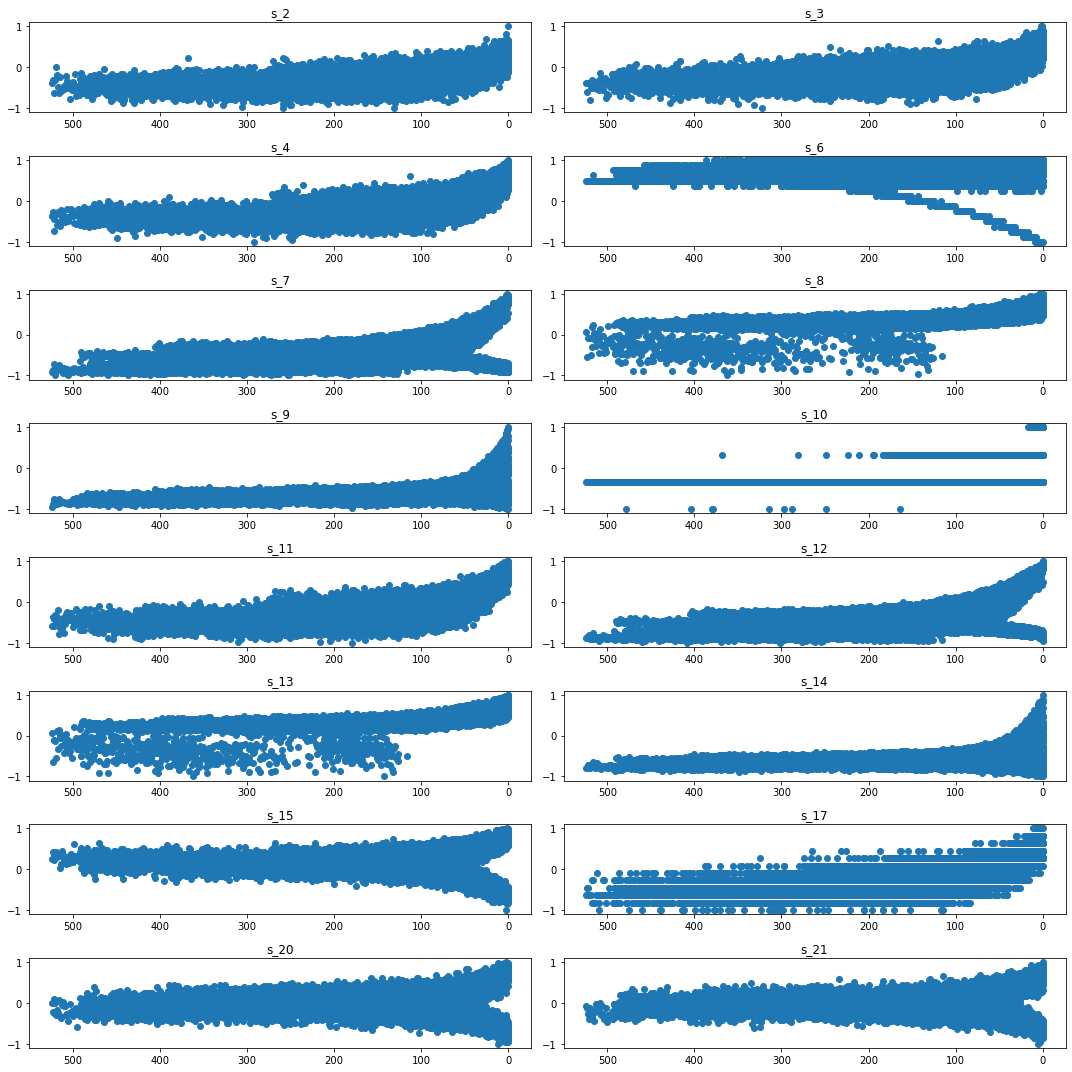

In [8]:
data =df
cols = math.ceil(len(sensor_columns)/8)
rows = math.ceil(len(sensor_columns)/cols)
plot_sensors(data, sensor_columns, cols, rows)

We can clearly see that sensor 10 does'nt contain any useful information about the remaining useful life.
What can also be seen, is that there are clearly two clusters, one for each fault mode. Let's try to seperate these fault modes. The sensors on which we seperate are sensor 15, 20 and 21, as these show clear seperations near the end of each units lifecycle.

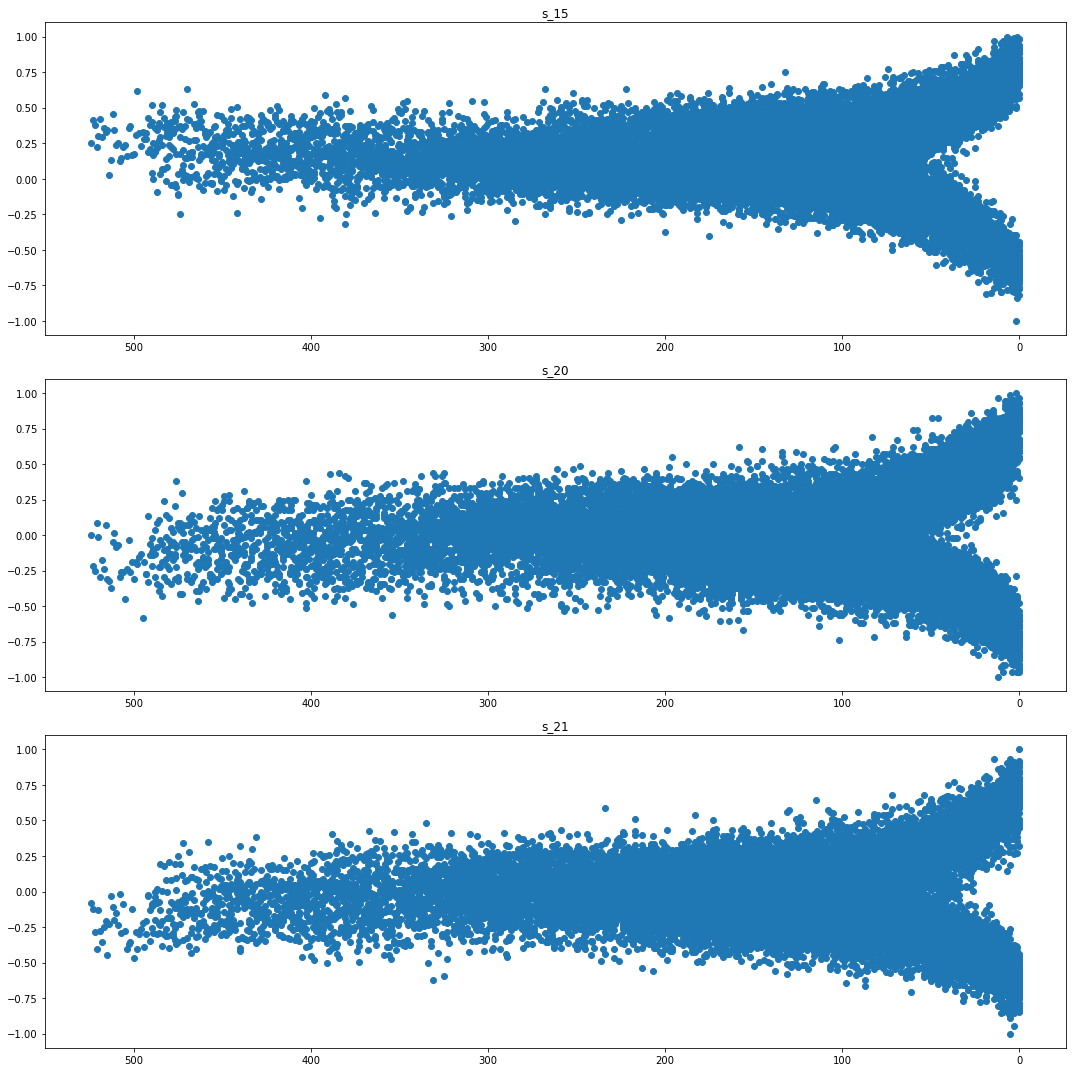

In [9]:
sensors = ['s_15', 's_20', 's_21']
plot_sensors(df, sensors, 1, 3)

In [10]:
def plot_clusters(data, sensors, cols, rows):
    fig, axes = plt.subplots(rows, cols, squeeze=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for row in range(0, rows):
        for col in range(0, cols):
            if cols*row+col < len(sensors):
                sensor = sensors[cols*row+col]
                axes[row][col].scatter(data['RUL'], data[sensor], c=data['cluster'], cmap='Set1')
                axes[row][col].invert_xaxis()
                axes[row][col].title.set_text(sensor)
    plt.tight_layout()

Let's start by using density clustering.

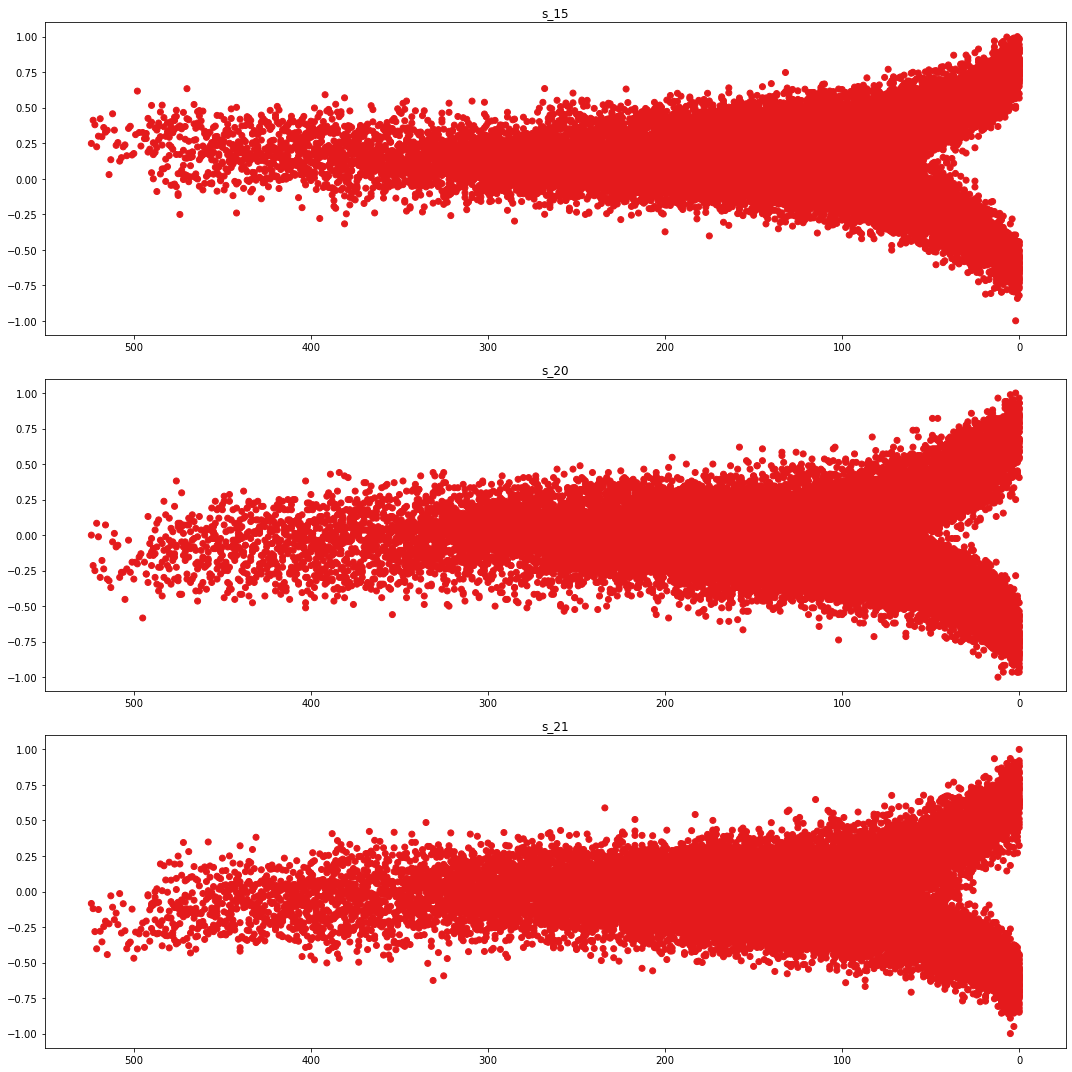

In [11]:
df_DBSCAN = df.copy()
db = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
y_db = db.fit_predict(df_DBSCAN[sensors])
df_DBSCAN['cluster']=pd.DataFrame(y_db)
plot_clusters(df_DBSCAN, sensors, 1, 3)

Let's also try K-means clustering with k=2 (the number of faults).

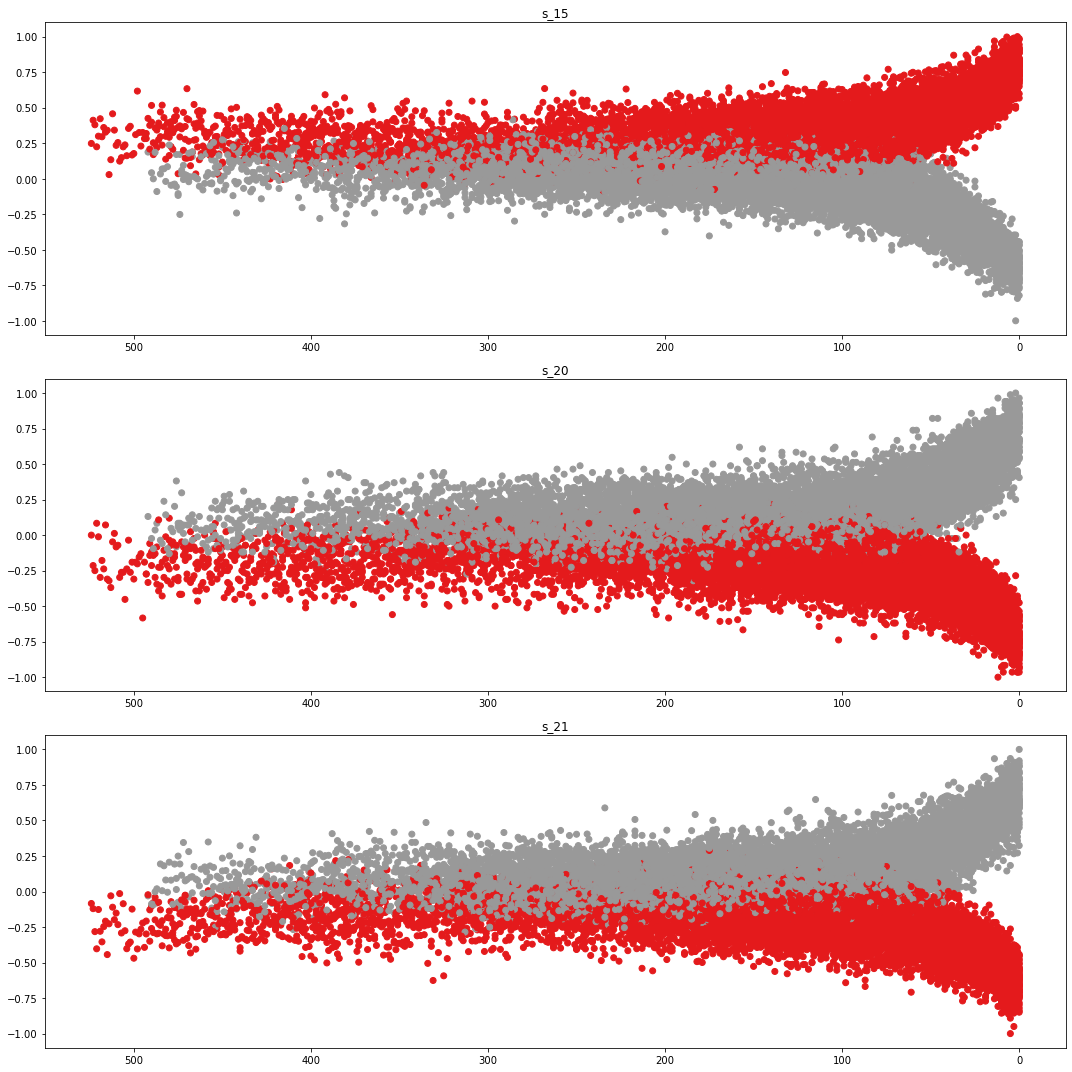

In [12]:
df_kmeans = df.copy()
km = KMeans(n_clusters=2, init='k-means++')
y_km = km.fit_predict(df_kmeans[sensors])
df_kmeans['cluster']=pd.DataFrame(y_km)
plot_clusters(df_kmeans, sensors, 1, 3)

We can clearly see that the K-means clustering seperates the two end-stages very well. We can use this to determine which fault eventually leads to the demise of the machine.
Obviously, the closer to failure the device gets, the more accurate the clusters become. At the beginning, each device operates in a normal, functioning state, so the clustering there means nothing.  
Finally, we'll indicate for each unit what fault will eventually destroy it and plot all sensors again, this time with the newly added fault-information.

In [23]:
df['cluster'] = df_kmeans[df_kmeans['RUL'] <= 20].groupby('unit_nr').mean()['cluster']

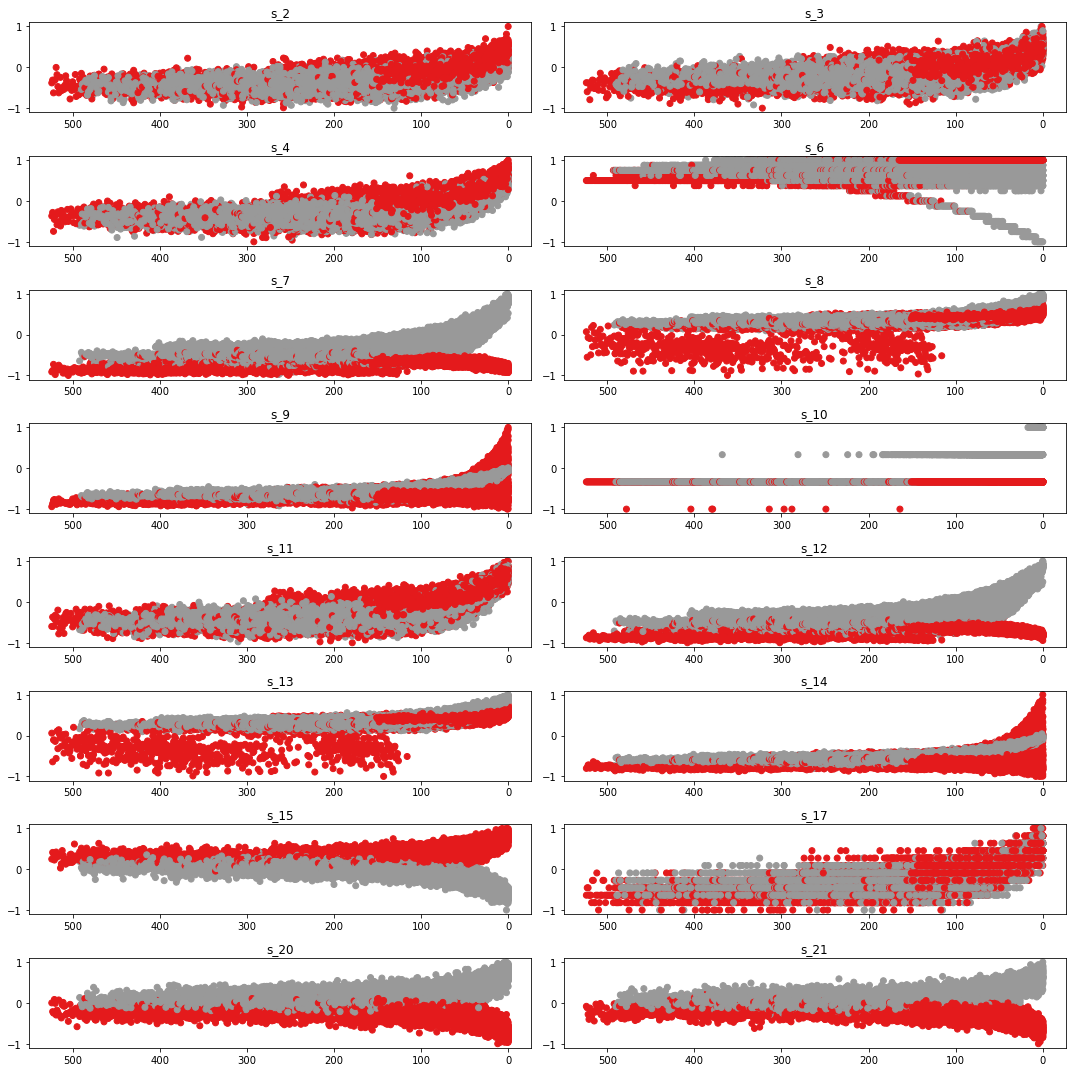

In [24]:
cols = math.ceil(len(sensor_columns)/8)
rows = math.ceil(len(sensor_columns)/cols)
plot_clusters(df_kmeans, sensor_columns, cols, rows)